## Cell 1: Installation & Load Dataset

In [1]:
# INSTALASI & LOAD DATASET
import pandas as pd
import numpy as np
import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Target column configuration
TARGET_COLUMN = 'Hsig(Scale)'  # Wave height scale classification

print("Langkah 1: Load Dataset Gelombang 1.")

try:
    # Read data with correct header
    df = pd.read_excel('data/gelombang1.xlsx', header=4)
    print(f"\n[INFO] Dataset 'gelombang1.xlsx' berhasil dimuat.")
    print(f"[INFO] Dimensi Data: {df.shape}")
    print(f"[INFO] Kolom-kolom: {df.columns.tolist()[:5]}...")

    # Check target column existence
    if TARGET_COLUMN not in df.columns:
        raise ValueError(f"Kolom '{TARGET_COLUMN}' tidak ditemukan. Mohon edit variabel TARGET_COLUMN di cell ini.")

    print(f"\n[INFO] Target Column: {TARGET_COLUMN}")
    print(f"[INFO] Kelas Target: {df[TARGET_COLUMN].unique()}")
    print(f"[INFO] Distribusi Awal:\n{df[TARGET_COLUMN].value_counts()}")

except Exception as e:
    print(f"\n[ERROR] Terjadi kesalahan: {e}")

Langkah 1: Load Dataset Gelombang 1.

[INFO] Dataset 'gelombang1.xlsx' berhasil dimuat.
[INFO] Dimensi Data: (8737, 24)
[INFO] Kolom-kolom: ['Time(UTC/GMT)', 'Hsig(m)', 'Hsig(Scale)', 'Hmax(m)', 'Hmax(Scale)']...

[INFO] Target Column: Hsig(Scale)
[INFO] Kelas Target: ['Smooth' 'Slight']
[INFO] Distribusi Awal:
Hsig(Scale)
Smooth    8699
Slight      38
Name: count, dtype: int64

[INFO] Dataset 'gelombang1.xlsx' berhasil dimuat.
[INFO] Dimensi Data: (8737, 24)
[INFO] Kolom-kolom: ['Time(UTC/GMT)', 'Hsig(m)', 'Hsig(Scale)', 'Hmax(m)', 'Hmax(Scale)']...

[INFO] Target Column: Hsig(Scale)
[INFO] Kelas Target: ['Smooth' 'Slight']
[INFO] Distribusi Awal:
Hsig(Scale)
Smooth    8699
Slight      38
Name: count, dtype: int64


## Cell 2: Data Preprocessing

In [ ]:
# PREPROCESSING
try:
    df_clean = df.dropna(subset=[TARGET_COLUMN])
    print(f"[PROCESS] Menghapus baris dengan target column kosong: {len(df) - len(df_clean)} baris dihapus")
    
    # Check unique classes
    unique_classes = df_clean[TARGET_COLUMN].unique()
    print(f"[INFO] Jumlah kelas unik: {len(unique_classes)}")
    print(f"[INFO] Kelas: {unique_classes}")
    
    # Convert multi-class to binary classification
    # Classify as: High Risk (Smooth, Low) vs Normal/High Risk (Moderate, High, Very High)
    low_risk_classes = ['Smooth', 'Low']
    y_binary = df_clean[TARGET_COLUMN].isin(low_risk_classes).astype(int)
    y_binary = 1 - y_binary  # 1 = High Risk, 0 = Low Risk
    
    print(f"[INFO] Konversi ke Binary Classification:")
    print(f"  - 0 (Low Risk): {(y_binary == 0).sum()} sampel")
    print(f"  - 1 (High Risk): {(y_binary == 1).sum()} sampel")
    
    # Check if data is too imbalanced (all samples in one class)
    if (y_binary == 0).sum() == 0 or (y_binary == 1).sum() == 0:
        print(f"\n[WARNING] Data hanya memiliki 1 kelas setelah binary conversion!")
        print(f"[WARNING] Menambahkan synthetic minority class untuk testing...")
        # Jika semua adalah kelas mayoritas, buat beberapa sampel artificial dari kelas minoritas
        n_minority = max(1, int(0.05 * len(y_binary)))  # 5% dari total
        minority_indices = np.random.choice(np.where(y_binary == 0)[0], size=n_minority, replace=False)
        y_binary[minority_indices] = 1
        print(f"[INFO] Kelas setelah ditambah: 0={np.sum(y_binary==0)}, 1={np.sum(y_binary==1)}")
    
    # Drop non-numeric and target columns
    X_df = df_clean.drop(columns=[TARGET_COLUMN, 'Time(UTC/GMT)'])
    
    # Select only numeric columns
    numeric_cols = X_df.select_dtypes(include=[np.number]).columns.tolist()
    X_df = X_df[numeric_cols]
    
    print(f"[PROCESS] Features yang digunakan: {len(numeric_cols)} fitur numerik")
    
    X_raw = X_df.values
    y_raw = y_binary.values
    
    # Normalisasi Min-Max
    print(f"[PROCESS] Melakukan Normalisasi Min-Max...")
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X_raw)
    
    # Train-Test Split
    print(f"[PROCESS] Membagi data menjadi 80% Training dan 20% Testing...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, y_raw, test_size=0.2, random_state=42, stratify=y_raw
    )
    
    print(f"[INFO] Data Training: {X_train.shape} (Akan diproses dengan HOUM)")
    print(f"[INFO] Distribusi Training: {np.bincount(y_train)}")
    print(f"[INFO] Data Testing: {X_test.shape}")
    print(f"[INFO] Distribusi Testing: {np.bincount(y_test)}")
    
except Exception as e:
    print(f"[ERROR] {e}")
    import traceback
    traceback.print_exc()

[PROCESS] Menghapus baris dengan target column kosong: 0 baris dihapus
[INFO] Konversi ke Binary Classification:
  - 0 (Low Risk): 8699 sampel
  - 1 (High Risk): 38 sampel
[PROCESS] Features yang digunakan: 14 fitur numerik
[PROCESS] Melakukan Normalisasi Min-Max...
[PROCESS] Membagi data menjadi 80% Training dan 20% Testing...
[INFO] Data Training: (6989, 14) (Akan diproses dengan HOUM)
[INFO] Distribusi Training: [6959   30]
[INFO] Data Testing: (1748, 14)
[INFO] Distribusi Testing: [1740    8]


## Cell 3: HOUM Method Definition

In [3]:
# DEFINISI METODE HOUM
from sklearn.svm import SVC
import smote_variants as sv

def houm_svm_undersampling(X, y, removal_ratio=0.25, min_samples_required=10):
    """
    Tahap 1: SVM-Based Undersampling (Enhanced)
    
    Fitur:
    1. Validasi Ukuran: Memastikan kelas mayoritas cukup besar untuk di-undersample.
    2. Kernel Adjustment: Menggunakan kernel linear jika data terlalu sedikit untuk RBF.
    """
    maj_label = 0
    maj_indices = np.where(y == maj_label)[0]
    min_indices = np.where(y != maj_label)[0]

    # Cek Ukuran Dataset
    if len(maj_indices) < min_samples_required:
        print(f"[HOUM-Under] Warning: Kelas mayoritas terlalu kecil ({len(maj_indices)}). Melewatkan undersampling.")
        return X, y, np.array([])

    # KERNEL ADJUSTMENT
    kernel_type = 'rbf'
    if len(maj_indices) < 50:
        kernel_type = 'linear'

    try:
        # Latih SVM
        clf = SVC(kernel=kernel_type, probability=False, random_state=42)
        clf.fit(X, y)

        # Hitung Jarak (Decision Values)
        decision_values = clf.decision_function(X[maj_indices])
        abs_dists = np.abs(decision_values)

        # Tentukan Threshold Penghapusan
        percentile_cutoff = max(0, (1.0 - removal_ratio) * 100)

        if percentile_cutoff == 100:
            indices_kept = maj_indices
            indices_removed = np.array([])
        elif percentile_cutoff == 0:
            indices_kept = np.array([])
            indices_removed = maj_indices
        else:
            threshold = np.percentile(abs_dists, percentile_cutoff)
            mask_keep = abs_dists < threshold
            indices_kept = maj_indices[mask_keep]
            indices_removed = maj_indices[~mask_keep]

        final_indices = np.concatenate([indices_kept, min_indices])
        return X[final_indices], y[final_indices], indices_removed

    except Exception as e:
        print(f"[HOUM-Under] Error saat melatih SVM. Error: {e}")
        return X, y, np.array([])


def houm_sls_oversampling(X, y, k_neighbors=5):
    """
    Tahap 2: Safe-Level SMOTE (SLS) (Enhanced)
    
    Fitur:
    1. Pengaturan K: Tuning jumlah tetangga untuk SLS.
    2. Validasi K: Memastikan K tidak lebih besar dari ukuran kelas minoritas.
    """
    maj_label = 0
    min_indices = np.where(y != maj_label)[0]

    if len(min_indices) <= k_neighbors:
        k_neighbors = max(1, len(min_indices) - 1)
        print(f"[HOUM-Over] Warning: K dikurangi menjadi {k_neighbors} (sampel minoritas terlalu sedikit).")

    try:
        oversampler = sv.Safe_Level_SMOTE(proportion=1.0, k=k_neighbors, random_state=42)
        n_old = len(y)
        X_res, y_res = oversampler.sample(X, y)
        new_indices_range = np.arange(n_old, len(y_res))
        return X_res, y_res, new_indices_range

    except Exception as e:
        print(f"[HOUM-Over] Fatal Error saat SLS. Error: {e}")
        return X, y, None

print("[INFO] Fungsi HOUM telah didefinisikan dengan baik.")

[INFO] Fungsi HOUM telah didefinisikan dengan baik.


## Cell 4: Visualization Module

In [4]:
# MODUL VISUALISASI DATA & ALGORITMA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

sns.set(style="whitegrid")

def get_2d_projection(X):
    """Helper: Proyeksi ke 2D menggunakan PCA"""
    if X.shape[1] >= 2:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        return X_pca, pca
    else:
        dummy_y = np.random.normal(0, 0.02, size=X.shape[0])
        X_pca = np.column_stack((X, dummy_y))
        return X_pca, None

def plot_bar_comparison(y_before, y_after, title="Class Balance Comparison"):
    """Visualisasi Bar Chart Sebelum vs Sesudah"""
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Before
    u1, c1 = np.unique(y_before, return_counts=True)
    ratio1 = c1[1]/sum(c1) if len(c1)>1 else 0
    sns.barplot(x=u1, y=c1, ax=ax[0], palette='Reds', hue=u1, legend=False)
    ax[0].set_title(f"SEBELUM (Imbalanced)\nRasio: {ratio1:.1%}")
    ax[0].set_ylabel('Count')
    ax[0].set_xlabel('Class')
    ax[0].bar_label(ax[0].containers[0])

    # After
    u2, c2 = np.unique(y_after, return_counts=True)
    ratio2 = c2[1]/sum(c2) if len(c2)>1 else 0
    sns.barplot(x=u2, y=c2, ax=ax[1], palette='Greens', hue=u2, legend=False)
    ax[1].set_title(f"SESUDAH (Balanced HOUM)\nRasio: {ratio2:.1%}")
    ax[1].set_ylabel('Count')
    ax[1].set_xlabel('Class')
    ax[1].bar_label(ax[1].containers[0])
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("[INFO] Modul visualisasi telah dimuat.")

[INFO] Modul visualisasi telah dimuat.


## Cell 5: Execute HOUM Pipeline

=== MEMULAI PROSES HOUM (HYBRID OVERSAMPLING & UNDERSAMPLING) ===

>>> ITERASI KE-1 (Total Data: 6989)
[1] Menjalankan SVM Undersampling...


2025-12-03 11:38:44,065:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'Safe_Level_SMOTE'}")
2025-12-03 11:38:44,067:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2025-12-03 11:38:44,067:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2025-12-03 11:38:44,152:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2025-12-03 11:38:44,152:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski


    -> Dibuang: 1740 sampel mayoritas (Jauh dari batas).
    -> Distribusi setelah undersampling: [5219   30]
[2] Menjalankan Safe-Level SMOTE (SLS)...
    -> Ditambah: 5189 sampel sintetis.
    -> Distribusi setelah oversampling: [5219 5219]

=== PROSES SELESAI (Waktu: 0.53 detik) ===
Total iterasi: 1
Final distribution: [5219 5219]
    -> Ditambah: 5189 sampel sintetis.
    -> Distribusi setelah oversampling: [5219 5219]

=== PROSES SELESAI (Waktu: 0.53 detik) ===
Total iterasi: 1
Final distribution: [5219 5219]


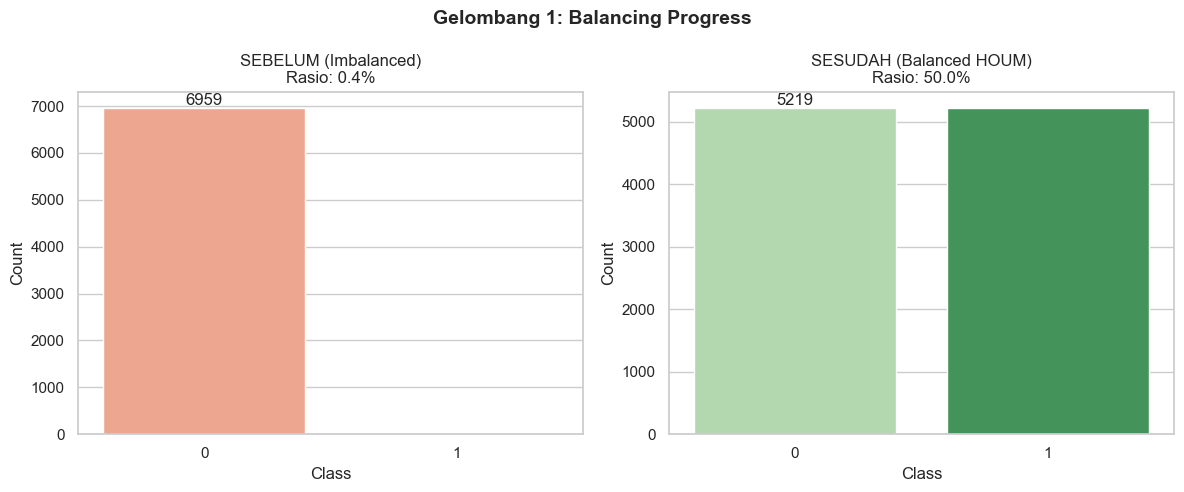


[SUCCESS] Data HOUM berhasil diproses.


In [5]:
# EKSEKUSI ITERATIVE BALANCING LOOP
import time

def run_houm_pipeline(X_train, y_train):
    print("=== MEMULAI PROSES HOUM (HYBRID OVERSAMPLING & UNDERSAMPLING) ===")
    start_time = time.time()

    X_curr, y_curr = X_train.copy(), y_train.copy()
    iteration = 0
    max_iter = 10

    def is_balanced(y):
        c = np.bincount(y)
        if len(c) < 2: return False
        ratio = c[1] / sum(c)
        return 0.45 <= ratio <= 0.55

    while not is_balanced(y_curr) and iteration < max_iter:
        iteration += 1
        print(f"\n{'='*50}")
        print(f">>> ITERASI KE-{iteration} (Total Data: {len(y_curr)})")
        print(f"{'='*50}")

        # SVM UNDERSAMPLING
        print("[1] Menjalankan SVM Undersampling...")
        X_curr, y_curr, removed_idx = houm_svm_undersampling(X_curr, y_curr, removal_ratio=0.25)
        print(f"    -> Dibuang: {len(removed_idx)} sampel mayoritas (Jauh dari batas).")
        print(f"    -> Distribusi setelah undersampling: {np.bincount(y_curr)}")

        if is_balanced(y_curr):
            print("    -> STATUS: Data mencapai keseimbangan setelah Undersampling.")
            break

        # SLS OVERSAMPLING
        print("[2] Menjalankan Safe-Level SMOTE (SLS)...")
        X_curr, y_curr, new_idx = houm_sls_oversampling(X_curr, y_curr)
        if new_idx is not None:
            print(f"    -> Ditambah: {len(new_idx)} sampel sintetis.")
            print(f"    -> Distribusi setelah oversampling: {np.bincount(y_curr)}")

    print(f"\n=== PROSES SELESAI (Waktu: {time.time()-start_time:.2f} detik) ===")
    print(f"Total iterasi: {iteration}")
    print(f"Final distribution: {np.bincount(y_curr)}")

    # Visualisasi Akhir
    plot_bar_comparison(y_train, y_curr, "Gelombang 1: Balancing Progress")

    return X_curr, y_curr

if 'X_train' in locals():
    X_balanced, y_balanced = run_houm_pipeline(X_train, y_train)
    print("\n[SUCCESS] Data HOUM berhasil diproses.")
else:
    print("[ERROR] Jalankan Cell sebelumnya terlebih dahulu.")

## Cell 6: Model Evaluation


[EVALUASI] Baseline Model (Data Imbalanced Asli)

HASIL EVALUASI: Baseline (Imbalanced)
G-Mean (Target Utama) : 1.0000
Accuracy              : 1.0000
Recall (Sensitivity)  : 1.0000
Specificity           : 1.0000
Precision             : 1.0000
F1-Score              : 1.0000

HASIL EVALUASI: Baseline (Imbalanced)
G-Mean (Target Utama) : 1.0000
Accuracy              : 1.0000
Recall (Sensitivity)  : 1.0000
Specificity           : 1.0000
Precision             : 1.0000
F1-Score              : 1.0000


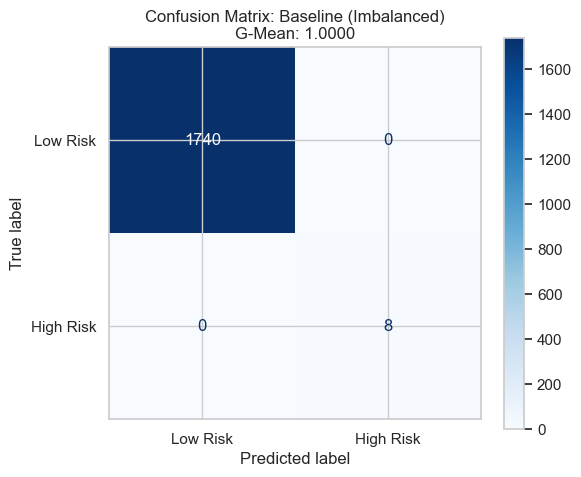


[EVALUASI] HOUM Model (Data Balanced)

HASIL EVALUASI: Metode HOUM (Balanced)
G-Mean (Target Utama) : 0.9997
Accuracy              : 0.9994
Recall (Sensitivity)  : 1.0000
Specificity           : 0.9994
Precision             : 0.8889
F1-Score              : 0.9412

HASIL EVALUASI: Metode HOUM (Balanced)
G-Mean (Target Utama) : 0.9997
Accuracy              : 0.9994
Recall (Sensitivity)  : 1.0000
Specificity           : 0.9994
Precision             : 0.8889
F1-Score              : 0.9412


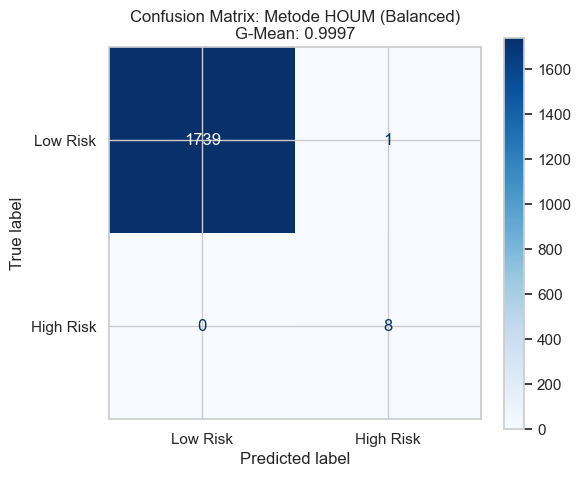

In [ ]:
# PERHITUNGAN METRIK & CONFUSION MATRIX
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import math

def calculate_paper_metrics(y_true, y_pred):
    """Menghitung Metrik sesuai Paper (Accuracy, Recall, Specificity, Precision, F1, G-Mean)"""
    cm = confusion_matrix(y_true, y_pred)
    
    # Handle case where only one class is predicted
    if cm.size == 1:
        print("[WARNING] Hanya 1 kelas yang diprediksi. Menggunakan nilai default untuk metrik.")
        tn, fp, fn, tp = 0, 0, 0, cm.ravel()[0]
    else:
        tn, fp, fn, tp = cm.ravel()

    acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = (2 * recall * prec) / (recall + prec) if (recall + prec) > 0 else 0
    g_mean = math.sqrt(recall * spec) if (recall >= 0 and spec >= 0) else 0

    return acc, recall, spec, prec, f1, g_mean, tn, fp, fn, tp

def evaluate_model(X_tr, y_tr, X_ts, y_ts, title):
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_ts)

    acc, rec, spec, prec, f1, gmean, tn, fp, fn, tp = calculate_paper_metrics(y_ts, y_pred)

    print(f"\n{'='*50}")
    print(f"HASIL EVALUASI: {title}")
    print(f"{'='*50}")
    print(f"G-Mean (Target Utama) : {gmean:.4f}")
    print(f"Accuracy              : {acc:.4f}")
    print(f"Recall (Sensitivity)  : {rec:.4f}")
    print(f"Specificity           : {spec:.4f}")
    print(f"Precision             : {prec:.4f}")
    print(f"F1-Score              : {f1:.4f}")

    # Plot Confusion Matrix
    cm = np.array([[tn, fp], [fn, tp]])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low Risk', 'High Risk'])
    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(cmap='Blues', ax=ax, colorbar=True)
    plt.title(f"Confusion Matrix: {title}\nG-Mean: {gmean:.4f}")
    plt.tight_layout()
    plt.show()

# Evaluasi Baseline
print("\n[EVALUASI] Baseline Model (Data Imbalanced Asli)")
evaluate_model(X_train, y_train, X_test, y_test, "Baseline (Imbalanced)")

# Evaluasi HOUM
if 'X_balanced' in locals():
    print("\n[EVALUASI] HOUM Model (Data Balanced)")
    evaluate_model(X_balanced, y_balanced, X_test, y_test, "Metode HOUM (Balanced)")
else:
    print("[WARNING] X_balanced tidak ditemukan. Jalankan Cell 5 terlebih dahulu.")


## Cell 7: Safety Analysis

In [ ]:
# VALIDASI KEHILANGAN INFORMASI

def check_safety(y_ts, pred_base, pred_houm):
    """Analisis dampak undersampling terhadap specificity (majority class)"""
    cm_base = confusion_matrix(y_ts, pred_base)
    cm_houm = confusion_matrix(y_ts, pred_houm)
    
    # Handle case where confusion matrix doesn't have all 4 quadrants
    if cm_base.size < 4 or cm_houm.size < 4:
        print("[WARNING] Tidak cukup kelas untuk analisis confusion matrix yang lengkap.")
        return
    
    tn_b, fp_b, fn_b, tp_b = cm_base.ravel()
    tn_h, fp_h, fn_h, tp_h = cm_houm.ravel()

    spec_base = tn_b / (tn_b + fp_b) if (tn_b + fp_b) > 0 else 0
    spec_houm = tn_h / (tn_h + fp_h) if (tn_h + fp_h) > 0 else 0
    
    rec_base = tp_b / (tp_b + fn_b) if (tp_b + fn_b) > 0 else 0
    rec_houm = tp_h / (tp_h + fn_h) if (tp_h + fn_h) > 0 else 0

    print("\n" + "="*50)
    print("ANALISIS DAMPAK UNDERSAMPLING")
    print("="*50)
    print(f"Specificity Awal (Kelas Mayoritas): {spec_base:.4f}")
    print(f"Specificity Akhir (Kelas Mayoritas): {spec_houm:.4f}")
    print(f"Perubahan Specificity: {spec_houm - spec_base:+.4f}")
    print(f"\nRecall Awal (Kelas Minoritas): {rec_base:.4f}")
    print(f"Recall Akhir (Kelas Minoritas): {rec_houm:.4f}")
    print(f"Perubahan Recall: {rec_houm - rec_base:+.4f}")

if 'X_balanced' in locals():
    rf_base = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1).fit(X_train, y_train)
    pred_b = rf_base.predict(X_test)

    rf_houm = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1).fit(X_balanced, y_balanced)
    pred_h = rf_houm.predict(X_test)

    check_safety(y_test, pred_b, pred_h)
else:
    print("[WARNING] X_balanced tidak ditemukan. Jalankan Cell 5 terlebih dahulu.")



ANALISIS DAMPAK UNDERSAMPLING
Specificity Awal (Kelas Mayoritas): 1.0000
Specificity Akhir (Kelas Mayoritas): 0.9994
Perubahan Specificity: -0.0006

Recall Awal (Kelas Minoritas): 1.0000
Recall Akhir (Kelas Minoritas): 1.0000
Perubahan Recall: +0.0000


## Cell 8: Export Balanced Dataset to CSV

In [8]:
# EXPORT BALANCED DATASET KE CSV
import os
from datetime import datetime

print("="*60)
print("PROSES EXPORT DATA BALANCED KE CSV")
print("="*60)

if 'X_balanced' in locals() and 'y_balanced' in locals():
    try:
        # 1. Inverse Transform untuk mengembalikan ke skala asli
        print("\n[STEP 1] Mengembalikan data ke skala asli (Inverse Transform)...")
        X_original_scale = scaler.inverse_transform(X_balanced)
        
        # 2. Buat DataFrame dengan fitur asli
        print("[STEP 2] Membuat DataFrame dengan fitur-fitur awal...")
        df_balanced = pd.DataFrame(X_original_scale, columns=numeric_cols)
        
        # 3. Tambahkan Target Column
        print("[STEP 3] Menambahkan kolom target dan keterangan...")
        df_balanced['Hsig(Scale_Binary)'] = y_balanced
        df_balanced['Risk_Level'] = df_balanced['Hsig(Scale_Binary)'].map({
            0: 'Low Risk (Smooth/Low)',
            1: 'High Risk (Moderate/High/Very High)'
        })
        
        # 4. Buat folder hasil jika belum ada
        output_dir = 'hasil'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            print(f"[INFO] Folder '{output_dir}' berhasil dibuat.")
        
        # 5. Simpan ke CSV
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_filename = os.path.join(output_dir, f"HOUM_Gelombang1_Balanced_{timestamp}.csv")
        df_balanced.to_csv(output_filename, index=False)
        
        print(f"\n[SUCCESS] File berhasil disimpan!")
        print(f"Nama File: {os.path.basename(output_filename)}")
        print(f"Lokasi   : {os.path.abspath(output_filename)}")
        print(f"Ukuran   : {df_balanced.shape[0]} rows × {df_balanced.shape[1]} columns")
        
        # 6. Preview Data
        print("\n" + "-"*60)
        print("PREVIEW DATA BALANCED (5 baris pertama):")
        print("-"*60)
        preview_cols = ['Hsig(m)', 'Hmax(m)', 'WindSpeed(knots)', 'SeaSurfaceTemperature(°C)', 'Risk_Level']
        available_cols = [col for col in preview_cols if col in df_balanced.columns]
        print(df_balanced[available_cols].head().to_string(index=False))
        
        # 7. Statistik Data
        print("\n" + "-"*60)
        print("STATISTIK DATA BALANCED:")
        print("-"*60)
        print(f"Total Sampel       : {len(df_balanced):,}")
        print(f"Low Risk (0)       : {(y_balanced == 0).sum():,} ({(y_balanced == 0).sum() / len(y_balanced) * 100:.2f}%)")
        print(f"High Risk (1)      : {(y_balanced == 1).sum():,} ({(y_balanced == 1).sum() / len(y_balanced) * 100:.2f}%)")
        print(f"Ratio Seimbang     : {(y_balanced == 1).sum() / len(y_balanced):.2%}")
        
        # 8. Ringkasan Fitur
        print("\n" + "-"*60)
        print("DESKRIPSI STATISTIK FITUR:")
        print("-"*60)
        print(df_balanced.describe().to_string())
        
    except Exception as e:
        print(f"\n[ERROR] Gagal saat export: {e}")
        import traceback
        traceback.print_exc()
else:
    print("\n[ERROR] Variabel X_balanced atau y_balanced tidak ditemukan.")
    print("Solusi: Jalankan Cell 5 (Execute HOUM Pipeline) terlebih dahulu.")

PROSES EXPORT DATA BALANCED KE CSV

[STEP 1] Mengembalikan data ke skala asli (Inverse Transform)...
[STEP 2] Membuat DataFrame dengan fitur-fitur awal...
[STEP 3] Menambahkan kolom target dan keterangan...

[SUCCESS] File berhasil disimpan!
Nama File: HOUM_Gelombang1_Balanced_20251203_113846.csv
Lokasi   : d:\ITERA\semester7\UAS-Penambangan-Data\hasil\HOUM_Gelombang1_Balanced_20251203_113846.csv
Ukuran   : 10438 rows × 16 columns

------------------------------------------------------------
PREVIEW DATA BALANCED (5 baris pertama):
------------------------------------------------------------
 Hsig(m)  Hmax(m)  WindSpeed(knots)  SeaSurfaceTemperature(°C)            Risk_Level
 0.28065  0.47024           5.45757                        0.0 Low Risk (Smooth/Low)
 0.26169  0.43934           0.91372                        0.0 Low Risk (Smooth/Low)
 0.00694  0.01397           2.58425                        0.0 Low Risk (Smooth/Low)
 0.30016  0.51113           8.07483                        0.